# Gradient Descent and Support Vector Regression
Overview of Implementation
1. <a href="#section1">Import Dataset</a>
2. <a href="#section2">Cleaning the Data for Model Training</a>
3. <a href="#section3">Gradient Descent</a>
4. <a href="#section4">Support Vector Regression</a>
5. <a href="#section5">Reducing Dimension: Feature selection</a>
6. <a href="#section6">Hyperparameter Tuning 1:polynomial degree</a>
7. <a href="#section7">Hyperparameter Tuning 2:polynomial degree (standardized features)</a>
8. <a href="#section8">Hyperparameter Tuning 3:regularization</a>
9. <a href="#section9">Hyperparameter Tuning 4:K-fold Cross Validation</a>

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from scipy import stats
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statistics import mean, median, mode, stdev
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from sklearn.model_selection import KFold

## <a id='section1'>Import Dataset</a>

In [2]:
train = pd.read_csv('train.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## <a id='section2'>Cleaning the Data for Model Training</a>
Remove the NA data and perform One Hot Encoding

In [3]:
nullData = [['LotFrontage', 259], ['MasVnrArea', 8], ['Electrical', 1], ['GarageYrBlt', 81]]
n = len(train)
treshold = 0.1
drop = []

print('Drop feature - too many nulls:')
for i in nullData:
    if i[1]/n > treshold: # Arbitrary treshold: 10%
        print(i[0])
        train.drop(columns=[i[0]], inplace=True)
    else:
        drop.append(i[0])
        
print('Remove data point:')
print(drop)
train.dropna(subset=drop, inplace=True)

train

Drop feature - too many nulls:
LotFrontage
Remove data point:
['MasVnrArea', 'Electrical', 'GarageYrBlt']


,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
#One-Hot encoding
categoricalcolumns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
train1 = pd.get_dummies(train, columns= categoricalcolumns, prefix= categoricalcolumns)
print(train1)

        Id  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0        1     8450       2003          2003       196.0         706   
1        2     9600       1976          1976         0.0         978   
2        3    11250       2001          2002       162.0         486   
3        4     9550       1915          1970         0.0         216   
4        5    14260       2000          2000       350.0         655   
...    ...      ...        ...           ...         ...         ...   
1455  1456     7917       1999          2000         0.0           0   
1456  1457    13175       1978          1988       119.0         790   
1457  1458     9042       1941          2006         0.0         275   
1458  1459     9717       1950          1996         0.0          49   
1459  1460     9937       1965          1965         0.0         830   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLw  \
0              0        150          856       856  ...     

## <a id='section3'>Gradient Descent</a> 
*insert description*


In [5]:
#train-test split
TEST_SIZE = 0.2

filteredData1 = train1.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE)

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

# initialisation for training data
x_train=train_X.to_numpy()
y_train=train_Y.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X.to_numpy()
y_test=test_Y.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

In [6]:
# predictive function definition
def f_pred(X,w): 
    f = X.dot(w)
    return f 

# loss function definition
def loss_mse(y_pred,y): 
    n = len(y)
    loss = 1/n* (y_pred - y).T.dot(y_pred - y) 
    return loss

# loss function definition
def loss_rmse(y_pred,y): 
    n = len(y)
    loss = 1/n* (y_pred - y).T.dot(y_pred - y) 
    return math.sqrt(loss)

# gradient function definition
def grad_loss(y_pred,y,X):
    n = len(y)
    grad = 2/n* X.T.dot(y_pred-y)
    return grad

# gradient descent function definition
def grad_desc(X, y , w_init=np.zeros(X.shape[1])[:,None] ,tau=0.01, max_iter=1000000,threshold=10**(3)):

    L_iters = np.zeros([max_iter]) # record the loss values
    w_iters = np.zeros([max_iter,X.shape[1]]) # record the loss values
    w = w_init # initialization
    break_condition=False
    for i in range(max_iter): # loop over the iterations
        y_pred = f_pred(X,w) # linear predicition function
        grad_f = grad_loss(y_pred,y,X) # gradient of the loss 
        w = w - tau* grad_f # update rule of gradient descent 
        L_iters[i] = loss_mse(y_pred,y) # save the current loss value 
        w_iters[i,:] = w.squeeze() # save the current w value 
        #stopping condition 1 
        if i>0:
            if (abs(L_iters[i]-L_iters[i-1])< threshold):
                L_iters=L_iters[:i+1]
                w_iters=w_iters[:i+1,:]
                break_condition=True
        #stopping condition 2
        if score(y_pred,y)-score(f_pred(X,w_iters[i-1]),y)<0.05:
                L_iters=L_iters[:i+1]
                w_iters=w_iters[:i+1,:]
                break_condition=True
        if break_condition==True:
            break

    return w, L_iters, w_iters

def score(y_pred,y_true):
    u=((y_true - y_pred) ** 2).sum()
    v=((y_true - y_true.mean()) ** 2).sum()
    return (1-u/v)

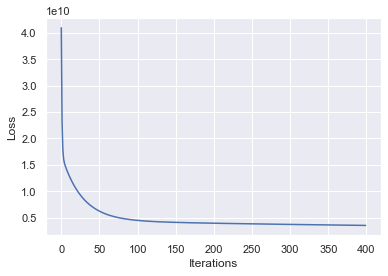

train loss mse = 3514670937.4179525
train accuracy score =  0.4477716216830726
test mse loss = [[3.19596885e+09]]
test accuracy score =  0.4335604849228535


In [7]:
# run gradient descent algorithm 
tau = 0.000000001
w_init= np.ones(X.shape[1])[:,None]*0
max_iter = 400
w, L_iters, w_iters = grad_desc(X,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_test,w)
test_loss = loss_mse(y_test_pred,y_test)
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))



In [8]:
#comparing the actual and the predicted SalePrice values
df = pd.DataFrame({'Real Values':test_Y, 'Predicted Values':y_test_pred.reshape(-1)})
df

,Real Values,Predicted Values
983,255900,216472.855279
1165,233170,200129.712311
141,260000,216162.973200
365,147000,169127.366187
577,164500,181190.146777
...,...,...
9,118000,164280.508479
480,326000,230336.250660
849,187000,186329.750283
176,211000,208317.342702


In [9]:
#Accuracy report
realVals = df["Real Values"]
predictedVals = df["Predicted Values"]
mse = mean_squared_error(realVals, predictedVals)
rmse = math.sqrt(mse)
print ("Mean square error (MSE) = ", mse)
print ("Root mean square error (RMSE) = ", rmse)
average_y = mean(realVals)
mbs = mean_absolute_error(realVals, predictedVals)
print("Mean absolute error (MBS) = ", mbs)
print ("The MBS occupies ",(mbs/average_y), " of the average SalePrice value")

Mean square error (MSE) =  3195968852.127116
Root mean square error (RMSE) =  56532.900616606574
Mean absolute error (MBS) =  40993.48366273863
The MBS occupies  0.2256469300407508  of the average SalePrice value


In [10]:
#Applying Standardization (Z-Score method)
continuous = ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
features_stand=train1.copy()
for i in continuous:
    # fit on training data column
    scale = StandardScaler().fit(train1[[i]])
    # transform training data column
    features_stand[i] = scale.transform(features_stand[[i]])
labels = train1['SalePrice']
features_stand.drop(['Id', 'SalePrice'], axis=1, inplace=True)

In [11]:
train_X_stan, test_X_stan, train_Y_stan, test_Y_stan = train_test_split(features_stand,labels,test_size=0.2, random_state=0)

In [12]:
# initialisation for training data
x_train_stan=train_X_stan.to_numpy()
y_train_stan=train_Y_stan.to_numpy()[:,None]
n_train_stan=x_train_stan.shape[0]
f_train_stan=x_train_stan.shape[1]
X_stan = np.ones([n_train_stan,f_train_stan+1]) 
X_stan[:,1:] = x_train_stan

# initialisation for test data 
x_test_stan=test_X_stan.to_numpy()
y_test_stan=test_Y_stan.to_numpy()[:,None]
n_test_stan=x_test_stan.shape[0]
f_test_stan=x_test_stan.shape[1]
X_test_stan = np.ones([n_test_stan,f_test_stan+1]) 
X_test_stan[:,1:] = x_test_stan

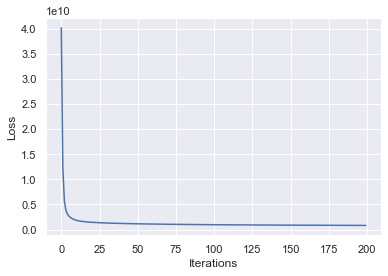

train loss mse = 832336532.1687522
train accuracy score =  0.864326224934449
test mse loss = [[2.23292675e+09]]
test accuracy score =  0.6605929228812941


In [13]:
#run gradient descent algorithm 
tau = 0.01
w_init= np.ones(X.shape[1])[:,None]*0
max_iter = 200
w, L_iters, w_iters = grad_desc(X_stan,y_train_stan,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
print('train loss mse =',L_iters[-1])
y_train_pred_stan=f_pred(X_stan,w)
print("train accuracy score = ",score(y_train_pred_stan,y_train_stan))

y_test_pred_stan=f_pred(X_test_stan,w)
test_loss_stan = loss_mse(y_test_pred_stan,y_test_stan)
print('test mse loss =',test_loss_stan)
print("test accuracy score = ",score(y_test_pred_stan,y_test_stan))


In [14]:
#comparing the actual and the predicted SalePrice values
df = pd.DataFrame({'Real Values':test_Y_stan, 'Predicted Values':y_test_pred_stan.reshape(-1)})
df

,Real Values,Predicted Values
1217,229456,219392.623985
1065,328000,282428.315718
1414,207000,183033.552392
31,149350,141825.011135
272,290000,296875.972109
...,...,...
998,91000,90518.694459
702,361919,335954.449961
270,266000,257882.080238
958,185000,196858.796910


In [15]:
#Accuracy report
realVals = df["Real Values"]
predictedVals = df["Predicted Values"]
mse = mean_squared_error(realVals, predictedVals)
rmse = math.sqrt(mse)
print ("Mean square error (MSE) = ", mse)
print ("Root mean square error (RMSE) = ", rmse)
average_y = mean(realVals)
mbs = mean_absolute_error(realVals, predictedVals)
print("Mean absolute error (MBS) = ", mbs)
print ("The MBS occupies ",(mbs/average_y), " of the average SalePrice value")

Mean square error (MSE) =  2232926747.0005603
Root mean square error (RMSE) =  47253.85430841129
Mean absolute error (MBS) =  20827.37329076261
The MBS occupies  0.11075235953864193  of the average SalePrice value


## <a id='section4'>Support Vector Regression</a>
With different kernel type used in the algorithm.

In [16]:
# applying svr with default rbf kernel
regr = make_pipeline(StandardScaler(), SVR(C=0.0001, epsilon=10))
regr.fit(x_train, y_train.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train, y_train))
print ("Test accuracy = ", regr.score(x_test,y_test))
predicted_y=regr.predict(x_train)
mse = mean_squared_error(y_train, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test)
mse = mean_squared_error(y_test, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)

Train accuracy =  -0.04856008721863336
Test accuracy =  -0.03074553203970587
Root mean square error (RMSE) for training data =  81671.59631448989
Root mean square error (RMSE) for testing data =  76260.60183599021


In [17]:
# applying svr with polynomial kernel
regr = make_pipeline(StandardScaler(), SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1))
regr.fit(x_train, y_train.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train, y_train))
print ("Test accuracy = ", regr.score(x_test,y_test))
predicted_y=regr.predict(x_train)
mse = mean_squared_error(y_train, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test)
mse = mean_squared_error(y_test, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)

Train accuracy =  0.22809902758210465
Test accuracy =  0.2513848134723433
Root mean square error (RMSE) for training data =  70073.7205582688
Root mean square error (RMSE) for testing data =  64991.0890369372


In [18]:
# applying svr with sigmoid kernel
regr = make_pipeline(StandardScaler(), SVR(kernel='sigmoid', C=100, gamma='auto'))
regr.fit(x_train, y_train.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train, y_train))
print ("Test accuracy = ", regr.score(x_test,y_test))
predicted_y=regr.predict(x_train)
mse = mean_squared_error(y_train, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test)
mse = mean_squared_error(y_test, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)

Train accuracy =  0.04475058169529689
Test accuracy =  0.0732443289626209
Root mean square error (RMSE) for training data =  77952.98928632253
Root mean square error (RMSE) for testing data =  72311.4589627109


In [19]:
# applying svr with linear kernel
regr = make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, gamma='auto'))
regr.fit(x_train, y_train.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train, y_train))
print ("Test accuracy = ", regr.score(x_test,y_test))
predicted_y=regr.predict(x_train)
mse = mean_squared_error(y_train, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test)
mse = mean_squared_error(y_test, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)

Train accuracy =  0.8848735338949908
Test accuracy =  0.8940437504063221
Root mean square error (RMSE) for training data =  27062.129619124567
Root mean square error (RMSE) for testing data =  24450.502367914076


In [20]:
best_train_accuracy=regr.score(x_train, y_train)
best_test_accuracy=regr.score(x_test,y_test)

Applying Standardization (Z-Score method)

In [21]:
# applying svr with default rbf kernel on stardardised features
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(x_train_stan, y_train_stan.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train_stan, y_train_stan))
print ("Test accuracy = ", regr.score(x_test_stan,y_test_stan))
predicted_y=regr.predict(x_train_stan)
mse = mean_squared_error(y_train_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test_stan)
mse = mean_squared_error(y_test_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)

Train accuracy =  -0.05831252036698964
Test accuracy =  -0.07681523250212074
Root mean square error (RMSE) for training data =  80534.85272417772
Root mean square error (RMSE) for testing data =  84168.07339375351


In [22]:
# applying svr with polynomial kernel on stardardised features
regr = make_pipeline(StandardScaler(), SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1))
regr.fit(x_train_stan, y_train_stan.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train_stan, y_train_stan))
print ("Test accuracy = ", regr.score(x_test_stan,y_test_stan))
predicted_y=regr.predict(x_train_stan)
mse = mean_squared_error(y_train_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test_stan)
mse = mean_squared_error(y_test_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)

Train accuracy =  0.23797390894050652
Test accuracy =  0.207467089340319
Root mean square error (RMSE) for training data =  68337.9304547899
Root mean square error (RMSE) for testing data =  72208.02124671584


In [23]:
# applying svr with sigmoid kernel on stardardised features
regr = make_pipeline(StandardScaler(), SVR(kernel='sigmoid', C=100, gamma='auto'))
regr.fit(x_train_stan, y_train_stan.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train_stan, y_train_stan))
print ("Test accuracy = ", regr.score(x_test_stan,y_test_stan))
predicted_y=regr.predict(x_train_stan)
mse = mean_squared_error(y_train_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test_stan)
mse = mean_squared_error(y_test_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)

Train accuracy =  0.04162426572832145
Test accuracy =  0.02641884961302332
Root mean square error (RMSE) for training data =  76638.11359445099
Root mean square error (RMSE) for testing data =  80031.8524803206


In [24]:
# applying svr with linear kernel on stardardised features
regr = make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, gamma='auto'))
regr.fit(x_train_stan, y_train_stan.ravel())
# calculating accuracy
print ("Train accuracy = ", regr.score(x_train_stan, y_train_stan))
print ("Test accuracy = ", regr.score(x_test_stan,y_test_stan))
predicted_y=regr.predict(x_train_stan)
mse = mean_squared_error(y_train_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for training data = ", rmse)
predicted_y = regr.predict(x_test_stan)
mse = mean_squared_error(y_test_stan, predicted_y)
rmse = math.sqrt(mse)
print ("Root mean square error (RMSE) for testing data = ", rmse)
print(mse)

Train accuracy =  0.9007669880661787
Test accuracy =  0.7367579264541054
Root mean square error (RMSE) for training data =  24660.676630671045
Root mean square error (RMSE) for testing data =  41615.43538460315
1731844462.25008


In [25]:
best_train_accuracy_new=regr.score(x_train_stan, y_train_stan)
best_test_accuracy_new=regr.score(x_test_stan,y_test_stan)

We then check if there is an improvement in accuracy after Z-score standardization

In [26]:
#improvement in accuracy
train_improvement = (best_train_accuracy_new - best_train_accuracy)/best_train_accuracy*100
test_improvement = (best_test_accuracy_new - best_test_accuracy)/best_test_accuracy*100
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = 1.7961271935921663 %
Test accuracy improvement = -17.59263166715655 %


## <a id='section5'>Reducing dimension: Feature selection</a>
Selecting features that has some correlation with SalesPrice
Setting the corelation threshold as 0.3  

In [27]:
# variables most closely related to SalePrice
corr = train1.corr()['SalePrice']
feature_select=[]
corrshape=corr.nlargest(corr.shape[0])[1:corr.shape[0]].shape[0]
for i in range(corrshape-1):
    if (abs(corr.nlargest(corrshape)[1:corrshape][i])>0.3):
        feature_select.append(corr.nlargest(corrshape)[1:corrshape].axes[0][i])
print(corr.nlargest(corrshape)[1:corrshape])
print(len(feature_select))

GrLivArea            0.709783
GarageCars           0.636173
GarageArea           0.607197
TotalBsmtSF          0.603284
1stFlrSF             0.596087
                       ...   
OverallQual_5       -0.383080
GarageType_Detchd   -0.406550
BsmtQual_TA         -0.456964
GarageFinish_Unf    -0.485273
KitchenQual_TA      -0.527689
Name: SalePrice, Length: 314, dtype: float64
47


In [28]:
#train-test split
TEST_SIZE = 0.2

filteredData2 = train1.drop(['Id'], axis=1)[feature_select+['SalePrice']]
train_df, test_df = train_test_split(filteredData2, test_size=TEST_SIZE)

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

# initialisation for training data
x_train=train_X.to_numpy()
y_train=train_Y.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X.to_numpy()
y_test=test_Y.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

## <a id='section6'>Hyperparameter tuning for gradient descent</a>
Using different polynomial degree in gradient descent model with selected features

In [29]:
# List of values of the polynomial degree d
train_error_tab = np.zeros(4)
val_error_tab = np.zeros(4)

In [30]:
# initialisation for training data
x_train=train_X.to_numpy()
y_train=train_Y.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X.to_numpy()
y_test=test_Y.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

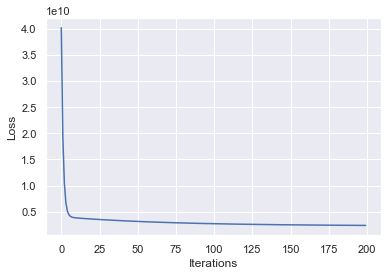

train loss mse = 2390313984.375424
train accuracy score =  0.6084552323934085
test mse loss = [[2.47759707e+09]]
test accuracy score =  0.6298748142070276


In [31]:
#Gradient descent with feature selection (threshold=0.3) with polynomial degree 1
tau = 0.00000001
w_init= np.zeros([X.shape[1]])[:,None]
max_iter = 200
w, L_iters, w_iters = grad_desc(X,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[0]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[0]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))

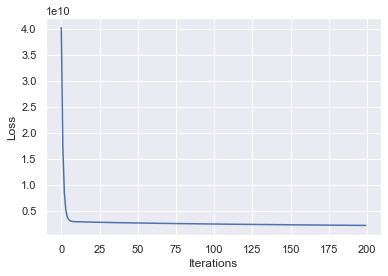

train loss mse = 2200211162.548227
train accuracy score =  0.6397105684376244
test mse loss = [[2.27240238e+09]]
test accuracy score =  0.6605285971594812


In [32]:
#Gradient descent with feature selection (threshold=0.3) with polynomial degree 2
poly = PolynomialFeatures(2)
X_d2 = poly.fit_transform(x_train)
X_d2_test = poly.fit_transform(x_test)
tau = 0.000000000000001
w_init= np.zeros([X_d2.shape[1]])[:,None]
max_iter = 200
w, L_iters, w_iters = grad_desc(X_d2,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[1]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X_d2,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_d2_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[1]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))

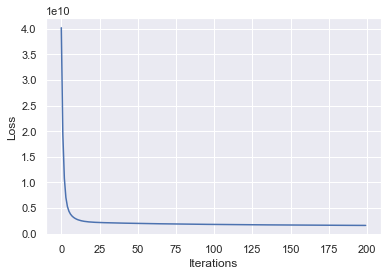

train loss mse = 1617171405.297593
train accuracy score =  0.7351289424006742
test mse loss = [[1.85439018e+09]]
test accuracy score =  0.7229749258411852


In [33]:
#Gradient descent with feature selection (threshold=0.3) with polynomial degree 3
poly = PolynomialFeatures(3)
X_d3 = poly.fit_transform(x_train)
X_d3_test = poly.fit_transform(x_test)
tau = 0.0000000000000000000001
w_init= np.zeros([X_d3.shape[1]])[:,None]
max_iter = 200
w, L_iters, w_iters = grad_desc(X_d3,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[2]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X_d3,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_d3_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[2]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))

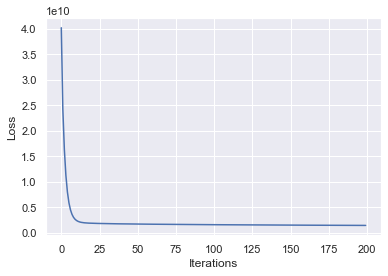

train loss mse = 1429421799.5812075
train accuracy score =  0.7658637326425746
test mse loss = [[1.65774764e+09]]
test accuracy score =  0.7523511146639289


In [34]:
#Gradient descent with feature selection (threshold=0.3) with polynomial degree 4
poly = PolynomialFeatures(4)
X_d4 = poly.fit_transform(x_train)
X_d4_test = poly.fit_transform(x_test)
tau = 10**(-29)
max_iter = 200
w_init= np.zeros([X_d4.shape[1]])[:,None]
w, L_iters, w_iters = grad_desc(X_d4,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[3]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X_d4,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_d4_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[3]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))

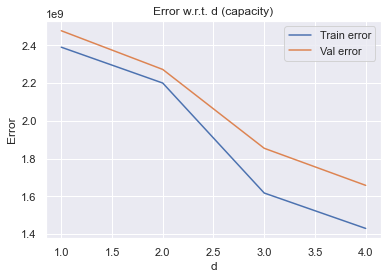

In [35]:
#Comparison of 4 different polynomial degree
x = [1,2,3,4]
plt.figure(1)
plt.plot(x, train_error_tab,label='Train error'.format(i=1))
plt.plot(x, val_error_tab,label='Val error'.format(i=2))
plt.legend(loc='best')
plt.title('Error w.r.t. d (capacity)')
plt.xlabel('d')
plt.ylabel('Error')
plt.show()

## <a id='section7'>Hyperparameter tuning for Gradient Descent + Feature Select + Standardization </a>
Using different polynomial degree in gradient descent model with selected standardized features

In [36]:
# List of values of the polynomial degree d
train_error_tab = np.zeros(4)
val_error_tab = np.zeros(4)

In [37]:
#Applying Standardization (Z-Score method)
continuous = ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
features_stand=train1.copy()
for i in continuous:
    # fit on training data column
    scale = StandardScaler().fit(train1[[i]])
    # transform training data column
    features_stand[i] = scale.transform(features_stand[[i]])
labels = train1['SalePrice']
features_stand.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X_stan, test_X_stan, train_Y_stan, test_Y_stan = train_test_split(features_stand[feature_select],labels,test_size=0.2, random_state=0)

# initialisation for training data
x_train=train_X_stan.to_numpy()
y_train=train_Y_stan.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X_stan.to_numpy()
y_test=test_Y_stan.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

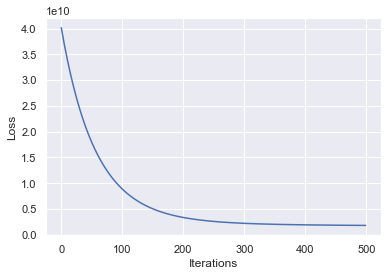

train loss mse = 1817725638.0127292
train accuracy score =  0.7035215054611459
test mse loss = [[2.86739068e+09]]
test accuracy score =  0.5641537771434368


In [38]:
#Gradient descent with feature selection (threshold=0.3), standardized features with polynomial degree 1
tau = 0.001
w_init= np.zeros([X.shape[1]])[:,None]
max_iter = 500
w, L_iters, w_iters = grad_desc(X,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[0]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[0]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))

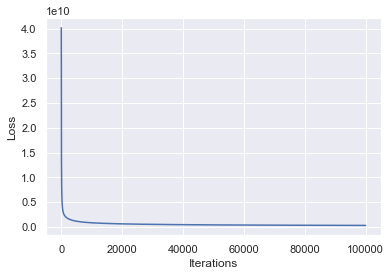

train loss mse = 300940934.638993
train accuracy score =  0.9508950045240564
test mse loss = [[8.34690925e+08]]
test accuracy score =  0.873126152616262


In [39]:
#Gradient descent with feature selection (threshold=0.3), standardized features with polynomial degree 2
poly = PolynomialFeatures(2)
X_d2 = poly.fit_transform(x_train)
X_d2_test = poly.fit_transform(x_test)
tau = 0.0001
w_init= np.zeros([X_d2.shape[1]])[:,None]
max_iter = 100000
w, L_iters, w_iters = grad_desc(X_d2,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[1]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X_d2,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_d2_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[1]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))
w_opt = w

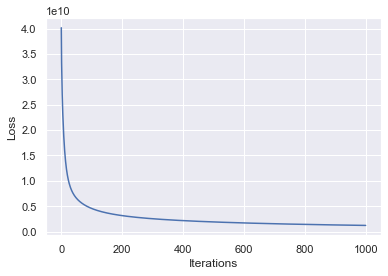

train loss mse = 1205850904.9660296
train accuracy score =  0.8033777434696853
test mse loss = [[6.76504145e+09]]
test accuracy score =  -0.02829300141654323


In [40]:
#Gradient descent with feature selection (threshold=0.3), standardized features with polynomial degree 3
poly = PolynomialFeatures(3)
X_d3 = poly.fit_transform(x_train)
X_d3_test = poly.fit_transform(x_test)
tau = 0.0001
w_init= np.zeros([X_d3.shape[1]])[:,None]
max_iter = 1000
w, L_iters, w_iters = grad_desc(X_d3,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[2]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X_d3,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_d3_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[2]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))

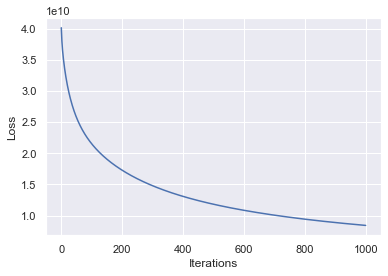

train loss mse = 8417206014.565198
train accuracy score =  -0.3727531203996546
test mse loss = [[1.0666444e+11]]
test accuracy score =  -15.213100476139921


In [41]:
#Gradient descent with feature selection (threshold=0.3), standardized features with polynomial degree 4
poly = PolynomialFeatures(4)
X_d4 = poly.fit_transform(x_train)
X_d4_test = poly.fit_transform(x_test)
tau = 0.000001
w_init= np.zeros([X_d4.shape[1]])[:,None]
max_iter = 1000
w, L_iters, w_iters = grad_desc(X_d4,y_train,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[3]=L_iters[-1]
print('train loss mse =',L_iters[-1])
y_train_pred=f_pred(X_d4,w)
print("train accuracy score = ",score(y_train_pred,y_train))

y_test_pred=f_pred(X_d4_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[3]=test_loss
print('test mse loss =',test_loss)
print("test accuracy score = ",score(y_test_pred,y_test))

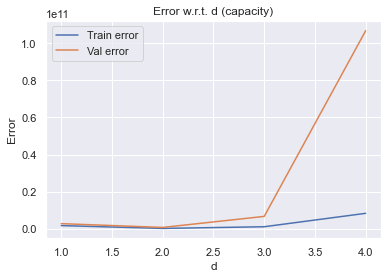

In [42]:
#Comparison of 4 different polynomial degree
x = [1,2,3,4]
plt.figure(1)
plt.plot(x, train_error_tab,label='Train error'.format(i=1))
plt.plot(x, val_error_tab,label='Val error'.format(i=2))
plt.legend(loc='best')
plt.title('Error w.r.t. d (capacity)')
plt.xlabel('d')
plt.ylabel('Error')
plt.show()

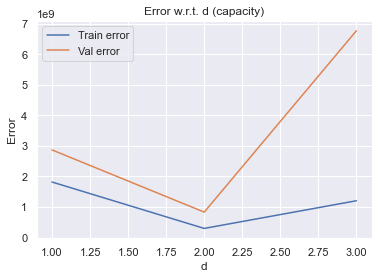

In [43]:
#Comparison between polynomial degree 1 to 3
x = [1,2,3]
plt.figure(1)
plt.plot(x, train_error_tab[:3],label='Train error'.format(i=1))
plt.plot(x, val_error_tab[:3],label='Val error'.format(i=2))
plt.legend(loc='best')
plt.title('Error w.r.t. d (capacity)')
plt.xlabel('d')
plt.ylabel('Error')
plt.show()

## <a id='section8'>Regularization for Gradient Descent</a>
Hyperparameter tuning for regularization in gradient descent model

In [44]:
# Regularized regression loss
def loss_regreg(w,X,y,reg): 
    n = len(y)
    y_pred = X.dot(w) 
    loss = 1/n* (y_pred - y).T.dot(y_pred - y)
    d = w.shape[0]
    loss += reg/d * w.T.dot(w)
    return loss

# gradient function definition
def grad_loss(y_pred,y,X,w,reg):
    n = len(y)
    d = w.shape[0]
    grad = 2/n* X.T.dot(y_pred-y) + (2*reg/d)*w
    return grad

# gradient descent function definition
def grad_desc(X, y , w_init=np.zeros(X.shape[1])[:,None] ,tau=0.01,reg=0, max_iter=1000000,threshold=10**(3)):

    L_iters = np.zeros([max_iter]) # record the loss values
    w_iters = np.zeros([max_iter,X.shape[1]]) # record the loss values
    w = w_init # initialization
    break_condition=False
    for i in range(max_iter): # loop over the iterations
        y_pred = f_pred(X,w) # linear predicition function
        grad_f = grad_loss(y_pred,y,X,w,reg) # gradient of the loss 
        w = w - tau* grad_f # update rule of gradient descent 
        L_iters[i] = loss_regreg(w,X,y,reg) # save the current loss value 
        w_iters[i,:] = w.squeeze() # save the current w value 
        #stopping condition 1
        if i>0:
            if (abs(L_iters[i]-L_iters[i-1])< threshold):
                L_iters=L_iters[:i+1]
                w_iters=w_iters[:i+1,:]
                break_condition=True
        #stopping condition 2
#        if score(y_pred,y)-score(f_pred(X,w_iters[i-1]),y)<0.05:
#                L_iters=L_iters[:i+1]
#                w_iters=w_iters[:i+1,:]
#                break_condition=True
        if break_condition==True:
            break

    return w, L_iters, w_iters

def compute_w_solution(X,y,tau,reg, max_iter):
    initial_w = np.zeros((X.shape[1],1))
    #gradient descent
    w, L_iters, w_iters = grad_desc(X, y , initial_w ,tau,reg, max_iter)
    loss_solution = L_iters[-1]
    return w, loss_solution

### Applying regularized gradient descent with feature selection (threshold=0.3), standardized features, polynomial degree 3

In [45]:
# regularization parameter λ = 0 when d = 3
tau = 0.0001
reg = 0
max_iter = 1000
w, train_loss_solution = compute_w_solution(X_d3,y_train,tau,reg,max_iter)
y_train_pred=f_pred(X_d3,w)
train_error=loss_mse(y_train_pred,y_train)
print('train loss mse =',train_error)
print("train accuracy score = ",score(y_train_pred,y_train))
y_test_pred=f_pred(X_d3_test,w)
test_error=loss_mse(y_test_pred,y_test)
print('test loss mse =',test_error)
print("test accuracy score = ",score(y_test_pred,y_test))

    

train loss mse = [[1.20499843e+09]]
train accuracy score =  0.8033777434696853
test loss mse = [[6.76504145e+09]]
test accuracy score =  -0.02829300141654323


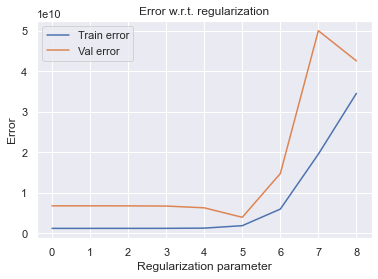

In [46]:
# List of values of the regularization parameter λ when d = 3
reg = np.array(range(0,9),np.float32)
reg = 10**reg
list_reg = list(reg)

d = 3
poly = PolynomialFeatures(d)

train_error_tab = np.zeros(len(list_reg))
val_error_tab = np.zeros(len(list_reg))

tau = 0.0001
max_iter = 1000
for i,reg in enumerate(list_reg):
    
    w, train_loss_solution = compute_w_solution(X_d3,y_train,tau,reg,max_iter)
    y_train_pred=f_pred(X_d3,w)
    train_error=loss_mse(y_train_pred,y_train)
    train_error_tab[i] = train_error
    
    y_test_pred=f_pred(X_d3_test,w)
    test_error=loss_mse(y_test_pred,y_test)
    val_error_tab[i] = test_error

    
# plot
x = np.array(range(0,9),np.float32)
plt.figure(1)
plt.plot(x, train_error_tab,label='Train error'.format(i=1))
plt.plot(x, val_error_tab,label='Val error'.format(i=2))
plt.legend(loc='best')
plt.title('Error w.r.t. regularization')
plt.xlabel('Regularization parameter')
plt.ylabel('Error')
plt.show()


In [47]:
# regularization parameter λ = 5 when d = 3
tau = 0.0001
reg = 10**(5)
max_iter = 1000
w, train_loss_solution = compute_w_solution(X_d3,y_train,tau,reg,max_iter)
y_train_pred=f_pred(X_d3,w)
train_error=loss_mse(y_train_pred,y_train)
print('train loss mse =',train_error)
print("train accuracy score = ",score(y_train_pred,y_train))
y_test_pred=f_pred(X_d3_test,w)
test_error=loss_mse(y_test_pred,y_test)
print('test loss mse =',test_error)
print("test accuracy score = ",score(y_test_pred,y_test))


train loss mse = [[1.86739701e+09]]
train accuracy score =  0.695292703073713
test loss mse = [[3.93585053e+09]]
test accuracy score =  0.40174682153647967


### Applying regularized gradient descent with feature selection (threshold=0.3), standardized features, polynomial degree 2

In [48]:
# regularization parameter λ = 0 when d = 2
tau = 0.0001
reg = 0
max_iter = 100000
w, train_loss_solution = compute_w_solution(X_d2,y_train,tau,reg,max_iter)
y_train_pred=f_pred(X_d2,w)
train_error=loss_mse(y_train_pred,y_train)
print('train loss mse =',train_error)
print("train accuracy score = ",score(y_train_pred,y_train))
y_test_pred=f_pred(X_d2_test,w)
test_error=loss_mse(y_test_pred,y_test)
print('test loss mse =',test_error)
print("test accuracy score = ",score(y_test_pred,y_test))

    

train loss mse = [[3.00939697e+08]]
train accuracy score =  0.9508950045240564
test loss mse = [[8.34690925e+08]]
test accuracy score =  0.873126152616262


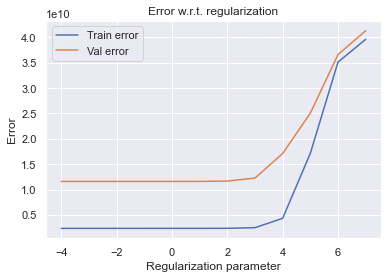

In [49]:
# List of values of the regularization parameter λ when d = 2
reg = np.array(range(-4,8),np.float32)
reg = 10**reg
list_reg = list(reg)

d = 2
poly = PolynomialFeatures(d)

train_error_tab = np.zeros(len(list_reg))
val_error_tab = np.zeros(len(list_reg))

tau = 0.0001
max_iter = 1000
for i,reg in enumerate(list_reg):
    w, train_loss_solution = compute_w_solution(X_d2,y_train,tau,reg,max_iter)
    y_train_pred=f_pred(X_d2,w)
    train_error=loss_mse(y_train_pred,y_train)
    train_error_tab[i] = train_error
    
    y_test_pred=f_pred(X_d2_test,w)
    test_error=loss_mse(y_test_pred,y_test)
    val_error_tab[i] = test_error

    
# plot
x = np.array(range(-4,8),np.float32)
plt.figure(1)
plt.plot(x, train_error_tab,label='Train error'.format(i=1))
plt.plot(x, val_error_tab,label='Val error'.format(i=2))
plt.legend(loc='best')
plt.title('Error w.r.t. regularization')
plt.xlabel('Regularization parameter')
plt.ylabel('Error')
plt.show()


## <a id='section9'>K-fold Cross Validation</a>

## Choosing hyperparameter via k-fold cross validation: regulariation parameter

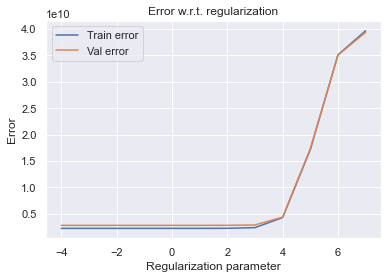

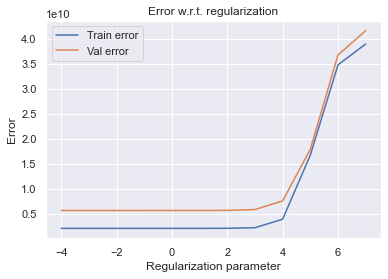

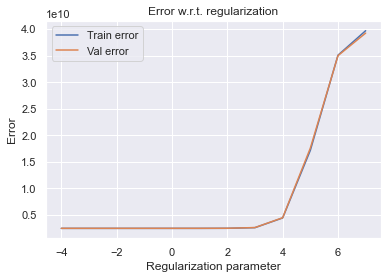

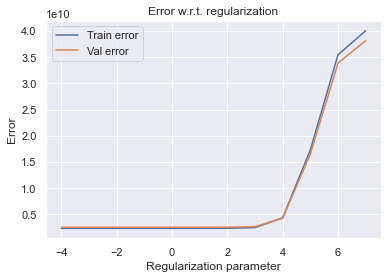

In [50]:
X=train_X_stan.to_numpy()
y=train_Y_stan.to_numpy()
kf = KFold(n_splits=4)
val_error_tab_tab = np.zeros([4,len(list_reg)])
k=0
for train_index, val_index  in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    #run algorithm for different hyperparameter
    reg = np.array(range(-4,8),np.float32)
    reg = 10**reg
    list_reg = list(reg)

    d = 2
    poly = PolynomialFeatures(d)
    X_d2 = poly.fit_transform(X_train)
    X_val_d2 = poly.fit_transform(X_val)
    train_error_tab = np.zeros(len(list_reg))
    val_error_tab = np.zeros(len(list_reg))

    tau = 0.0001
    max_iter = 1000
    for i,reg in enumerate(list_reg):
        w, train_loss_solution = compute_w_solution(X_d2,y_train[:,None],tau,reg,max_iter)
        y_train_pred=f_pred(X_d2,w)
        train_error=loss_mse(y_train_pred,y_train[:,None])
        train_error_tab[i] = train_error
    
        y_val_pred=f_pred(X_val_d2,w)
        val_error=loss_mse(y_val_pred,y_val[:,None])
        val_error_tab[i] = val_error

    val_error_tab_tab[k]=val_error_tab
    k+=1
    # plot
    x = np.array(range(-4,8),np.float32)
    plt.figure(1)
    plt.plot(x, train_error_tab,label='Train error'.format(i=1))
    plt.plot(x, val_error_tab,label='Val error'.format(i=2))
    plt.legend(loc='best')
    plt.title('Error w.r.t. regularization')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Error')
    plt.show()

#record Loss value for each hyperparameter
    
#after all iterations, calculate mean loss for each hyperparameter
    

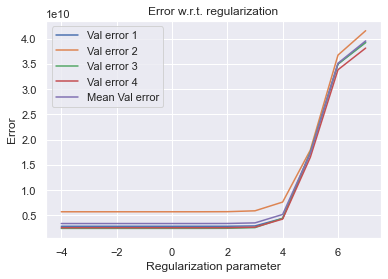

In [51]:
# plot
x = np.array(range(-4,8),np.float32)
plt.figure(1)
plt.plot(x, val_error_tab_tab[0],label='Val error 1'.format(i=1))
plt.plot(x, val_error_tab_tab[1],label='Val error 2'.format(i=2))
plt.plot(x, val_error_tab_tab[2],label='Val error 3'.format(i=3))
plt.plot(x, val_error_tab_tab[3],label='Val error 4'.format(i=4))
plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=5))
plt.legend(loc='best')
plt.title('Error w.r.t. regularization')
plt.xlabel('Regularization parameter')
plt.ylabel('Error')
plt.show()

## Choosing hyperparameter via k-fold cross validation: laerning rate

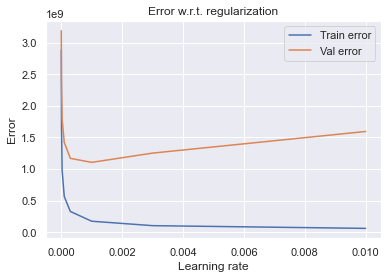

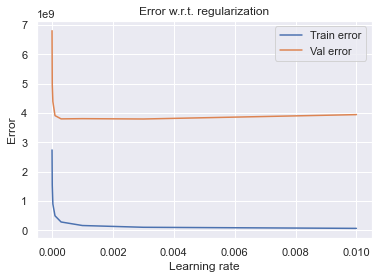

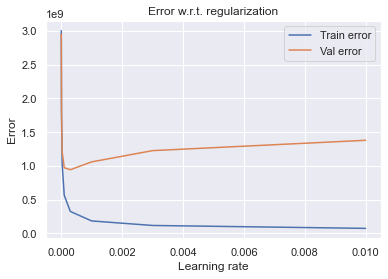

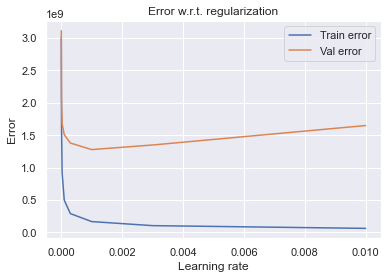

In [52]:
X=train_X_stan.to_numpy()
y=train_Y_stan.to_numpy()
kf = KFold(n_splits=4)

tau_list = [0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01]


val_error_tab_tab = np.zeros([kf.get_n_splits(X),len(tau_list)])
k=0

for train_index, val_index  in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    #run algorithm for different hyperparameter

    d = 2
    poly = PolynomialFeatures(d)
    X_d = poly.fit_transform(X_train)
    X_val_d = poly.fit_transform(X_val)
    train_error_tab = np.zeros(len(tau_list))
    val_error_tab = np.zeros(len(tau_list))

    reg=0
    max_iter = 20000
    for i,tau in enumerate(tau_list):
        w, train_loss_solution = compute_w_solution(X_d,y_train[:,None],tau,reg,max_iter)
        y_train_pred=f_pred(X_d,w)
        train_error=loss_mse(y_train_pred,y_train[:,None])
        train_error_tab[i] = train_error
    
        y_val_pred=f_pred(X_val_d,w)
        val_error=loss_mse(y_val_pred,y_val[:,None])
        val_error_tab[i] = val_error

    val_error_tab_tab[k]=val_error_tab
    k+=1
    
    # plot train error and val error
    x = [0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01]
    plt.figure(1)
    plt.plot(x, train_error_tab,label='Train error'.format(i=1))
    plt.plot(x, val_error_tab,label='Val error'.format(i=2))
    plt.legend(loc='best')
    plt.title('Error w.r.t. regularization')
    plt.xlabel('Learning rate')
    plt.ylabel('Error')
    plt.show()


    

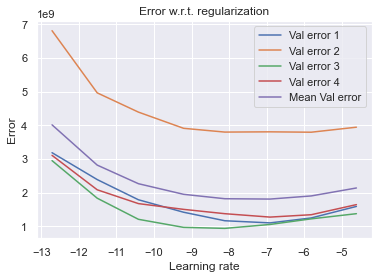

In [53]:
# plot
x = np.log([0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01])
plt.figure(1)
for k in range(kf.get_n_splits(X)):
    plt.plot(x, val_error_tab_tab[k],label=('Val error '+ str(k+1)) .format(i=(k+1)))

plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=(k+1)))
plt.legend(loc='best')
plt.title('Error w.r.t. regularization')
plt.xlabel('Learning rate')
plt.ylabel('Error')
plt.show()

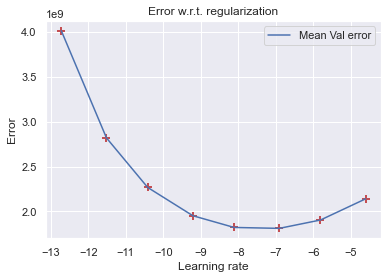

In [54]:
plt.figure(1)
plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=1))
plt.scatter(x, np.mean(val_error_tab_tab,axis=0), s=60, c='r', marker='+', linewidths=2) 
plt.legend(loc='best')
plt.title('Error w.r.t. regularization')
plt.xlabel('Learning rate')
plt.ylabel('Error')
plt.show()

In [55]:
np.mean(val_error_tab_tab,axis=0)


array([4.01392678e+09, 2.81953806e+09, 2.26788617e+09, 1.95277034e+09,
       1.82231227e+09, 1.81197531e+09, 1.90509244e+09, 2.14112042e+09])